# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

import thinkplot

## The Space Shuttle problem

Here's a problem from [Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb)

>On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1989.10478858)):



In [2]:
#!wget https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv

In [3]:
columns = ['Date', 'Temperature', 'Incident']
df = pd.read_csv('challenger_data.csv', parse_dates=[0])
df.drop(labels=[3, 24], inplace=True)
df

,Date,Temperature,Damage Incident
0,1981-04-12,66,0
1,1981-11-12,70,1
2,1982-03-22,69,0
4,1982-01-11,68,0
5,1983-04-04,67,0
6,1983-06-18,72,0
7,1983-08-30,73,0
8,1983-11-28,70,0
9,1984-02-03,57,1
10,1984-04-06,63,1


In [4]:
df['Incident'] = df['Damage Incident'].astype(float)
df

,Date,Temperature,Damage Incident,Incident
0,1981-04-12,66,0,0.0
1,1981-11-12,70,1,1.0
2,1982-03-22,69,0,0.0
4,1982-01-11,68,0,0.0
5,1983-04-04,67,0,0.0
6,1983-06-18,72,0,0.0
7,1983-08-30,73,0,0.0
8,1983-11-28,70,0,0.0
9,1984-02-03,57,1,1.0
10,1984-04-06,63,1,1.0


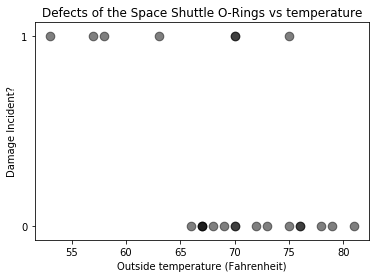

In [5]:
import matplotlib.pyplot as plt

plt.scatter(df.Temperature, df.Incident, s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

### Grid algorithm

We can solve the problem first using a grid algorithm, with parameters `b0` and `b1`, and

$\mathrm{logit}(p) = b0 + b1 * T$

and each datum being a temperature `T` and a boolean outcome `fail`, which is true is there was damage and false otherwise.

Hint: the `expit` function from `scipy.special` computes the inverse of the `logit` function.

In [6]:
from scipy.special import expit

class Logistic(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: T, fail
        hypo: b0, b1
        """
        T,fail=data;
        b0,b1=hypo;
        if fail:
            return expit(b0+b1*T)
        else:
            return 1-expit(b0+b1*T)

In [7]:
# Solution goes here

In [23]:
b0 = np.linspace(0, 50, 101);

In [24]:
b1 = np.linspace(-1, 1, 101);

In [25]:
from itertools import product
hypos = product(b0, b1)

In [26]:
suite = Logistic(hypos);

In [27]:
for data in zip(df.Temperature, df.Incident):
    #print(data)
    suite.Update(data)

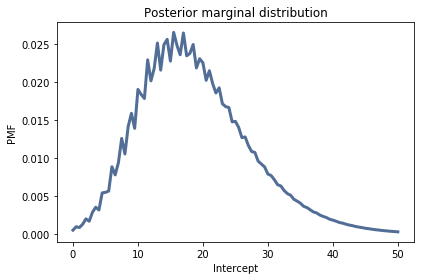

In [28]:
thinkplot.Pdf(suite.Marginal(0))
thinkplot.decorate(xlabel='Intercept',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

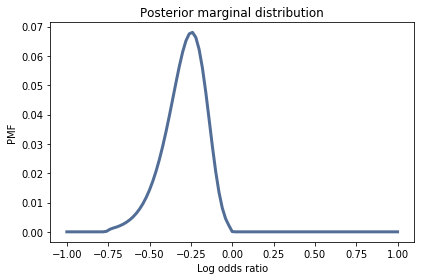

In [29]:
thinkplot.Pdf(suite.Marginal(1))
thinkplot.decorate(xlabel='Log odds ratio',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

According to the posterior distribution, what was the probability of damage when the shuttle launched at 31 degF?

In [33]:
suite.Copy().Update((31,True))

0.9909003512180481

In [40]:
Ptotal=0
for (b0,b1),p in suite.Items():
   Ptotal += expit(b0+b1*31)*p
print(P)

print(expit(suite.Marginal(0).Mean()+suite.Marginal(1).Mean()*31))

0.9909003512180481
0.9999505482267474


### MCMC

Implement this model using MCMC.  As a starting place, you can use this example from [the PyMC3 docs](https://docs.pymc.io/notebooks/GLM-logistic.html#The-model).

As a challege, try writing the model more explicitly, rather than using the GLM module.

In [17]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/henry/miniconda3/envs/ThinkBayse2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
# Solution goes here

In [19]:
pm.traceplot(trace);

NameError: name 'trace' is not defined

The posterior distributions for these parameters should be similar to what we got with the grid algorithm.